# Random Resnet Model

Reference: https://keras.io/guides/transfer_learning/

## Load and Split Dataset

In [1]:
!pip install tensorflow_addons

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa

# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9
MAX_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 50
BASE_LEARNING_RATE = 0.001
BATCH_SIZE = 64

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))
    
#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

2021-11-18 02:38:45.925349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 02:38:46.147444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 02:38:46.148185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 02:38:46.150633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Number of training samples: 192
Number of validation samples: 55
Number of test samples: 28


## Model Definition

In [4]:
base_model = tf.keras.applications.ResNet50(include_top = False, weights = None, input_shape = (256, 256, 3), pooling = None)
base_model.trainable = True

# Image augmentation layers
rotation_layer = tf.keras.layers.RandomRotation(0.5, seed = RANDOM_STATE)
flipping_layer = tf.keras.layers.RandomFlip(seed = RANDOM_STATE)

# Prediction layers
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')

inputs = tf.keras.Input(shape = (256, 256, 3))
x = flipping_layer(inputs)
x = rotation_layer(x)
x = tf.keras.applications.resnet50.preprocess_input(x) # convert RGB to BGR, then zero-center color channel wrt ImageNet without scaling
x = base_model(x, training = True)
x = pooling_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

adam = tf.keras.optimizers.Adam(learning_rate = BASE_LEARNING_RATE)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['Precision', 'Recall', 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [5]:
from sklearn.metrics import classification_report

def plotResults(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    precision = hist.history['precision']
    val_precision = hist.history['val_precision']
    recall = hist.history['recall']
    val_recall = hist.history['val_recall']

    # Plot the graph manually
    epochs = range(len(loss))

    plt.figure(figsize=(20, 20))
    plt.subplot(4, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(epochs, precision, 'r', label='Training Precision')
    plt.plot(epochs, val_precision, 'b', label='Validation Precision')
    plt.title('Training and validation Precision')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(epochs, recall, 'r', label = "Training Recall")
    plt.plot(epochs, val_recall, 'b', label='Validation Recall')
    plt.title('Training and validation Recall')
    plt.legend()

    plt.show()
    
def printClassificationReport(model, val_ds):
    # Convert validation dataset into X_val, y_val
    val_numpy = tfds.as_numpy(val_ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in val_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)

    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X_val = np.concatenate(X_batches, axis = 0)
    y_val = np.concatenate(y_batches, axis = 0)

    # Print classification report
    y_val = np.argmax(y_val, axis=1) # Convert one-hot to index
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index
    print(y_val.shape, y_pred.shape)

    print(classification_report(y_val, y_pred))

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, 
                                                  patience = EARLY_STOPPING_PATIENCE, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

finetuning_hist = model.fit(train_ds, validation_data = validation_ds, 
                    epochs = MAX_EPOCHS, callbacks = [early_stopping, reduce_lr], batch_size = BATCH_SIZE)

Epoch 1/1000


2021-11-18 02:38:54.565497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-18 02:38:59.303887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


192/192 [==============================] - 202s 932ms/step - loss: 1.5941 - precision: 0.6487 - recall: 0.3839 - accuracy: 0.5186 - val_loss: 1.3363 - val_precision: 0.6809 - val_recall: 0.4132 - val_accuracy: 0.5346
Epoch 2/1000
192/192 [==============================] - 174s 906ms/step - loss: 1.2607 - precision: 0.7069 - recall: 0.4296 - accuracy: 0.5688 - val_loss: 1.1354 - val_precision: 0.7451 - val_recall: 0.4340 - val_accuracy: 0.5974
Epoch 3/1000
192/192 [==============================] - 174s 906ms/step - loss: 1.1039 - precision: 0.7270 - recall: 0.4807 - accuracy: 0.6081 - val_loss: 1.0560 - val_precision: 0.7557 - val_recall: 0.4823 - val_accuracy: 0.6245
Epoch 4/1000
192/192 [==============================] - 174s 906ms/step - loss: 1.0347 - precision: 0.7456 - recall: 0.5069 - accuracy: 0.6367 - val_loss: 1.0228 - val_precision: 0.7719 - val_recall: 0.5286 - val_accuracy: 0.6505
Epoch 5/1000
192/192 [==============================] - 174s 905ms/step - loss: 0.9731 - prec

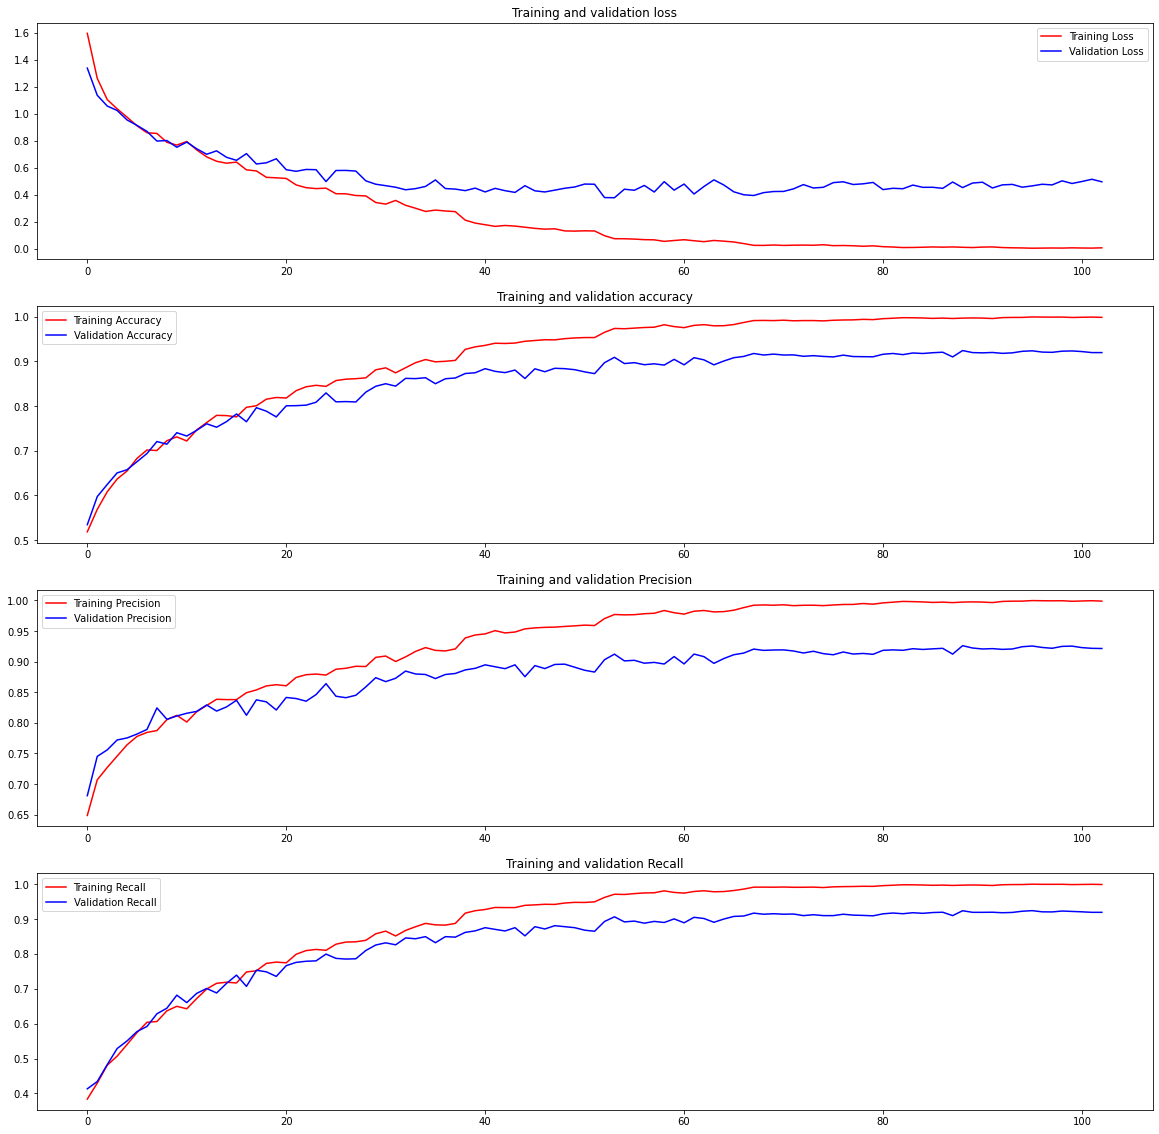

(3502,) (3502,)
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       253
           1       0.83      0.87      0.85       229
           2       0.95      0.94      0.95       199
           3       0.90      0.79      0.84       190
           4       0.80      0.90      0.85       222
           5       0.80      0.89      0.84       212
           6       0.91      0.83      0.87       203
           7       0.79      0.76      0.77       207
           8       0.93      0.94      0.94      1787

    accuracy                           0.89      3502
   macro avg       0.86      0.85      0.85      3502
weighted avg       0.89      0.89      0.89      3502



In [7]:
plotResults(finetuning_hist)
printClassificationReport(model, validation_ds)

In [8]:
model.save('resnet_random_model')

!zip -r resnet_random_model.zip resnet_random_model

2021-11-18 07:38:16.525629: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: resnet_random_model/assets


INFO:tensorflow:Assets written to: resnet_random_model/assets
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


  adding: resnet_random_model/ (stored 0%)
  adding: resnet_random_model/saved_model.pb (deflated 92%)
  adding: resnet_random_model/variables/ (stored 0%)
  adding: resnet_random_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: resnet_random_model/variables/variables.index (deflated 80%)
  adding: resnet_random_model/keras_metadata.pb (deflated 96%)
  adding: resnet_random_model/assets/ (stored 0%)
